In [1]:
import sys, os

import numpy as np

import pickle

import torch
from pytorch_msssim import MS_SSIM
from tqdm import tqdm

import model, generator, visuals




/home/garysnake/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
FOLDER_PATH = "/home/garysnake/Desktop/crsae/pytorch/results/default/2020_05_25_07_59_16/"
HYP_PATH = FOLDER_PATH+"hyp.pickle"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

file = open(HYP_PATH, "rb")
hyper_parameter = pickle.load(file)
file.close()
for name, val in hyper_parameter.items():
    print(str(name) + ": " + str(val))


experiment_name: default
dataset: VOC
network: CRsAE2DUntiedTrainableBias
dictionary_dim: 7
num_conv: 64
stride: 6
L: 5
trainable_bias: True
delta: 50
num_iters: 50
batch_size: 1
num_epochs: 30
normalize: True
lr: 0.0005
lr_decay: 0.7
lr_step: 20
lr_lam: 0.0001
cyclic: False
noiseSTD: 20
shuffle: True
test_path: ../data/test_img/
train_path: ../data/test_img/
device: cuda:0
warm_start: True
info_period: 10
denoising: True
supervised: True
crop_dim: [250, 250]
init_with_DCT: False
init_with_saved_file: False
sigma: 0.18
loss: L1
lam: 0.1
twosided: True
image_set: train
year: 2012
segmentation: True
redo: 1


In [3]:
MODEL_PATH = FOLDER_PATH+"model_epoch29.pt"
result_model = torch.load(MODEL_PATH)
dictionary = result_model.get_param("H").data
dictionary = dictionary.view((dictionary.size()[0],dictionary.size()[2],dictionary.size()[3]))
print(dictionary.size())


    

torch.Size([64, 7, 7])


In [18]:
all_epoch_loss = []

for i in range(29):
    file = open(FOLDER_PATH+"loss_epoch{}..npy".format(i), "rb")
    loss = np.load(file)
    print
    file.close()

    all_epoch_loss.append(loss)
all_epoch_loss = np.array(all_epoch_loss).reshape(-1)

print(all_epoch_loss.mean())

print(np.size(all_epoch_loss))

    

16329.955670923186
42456


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss')

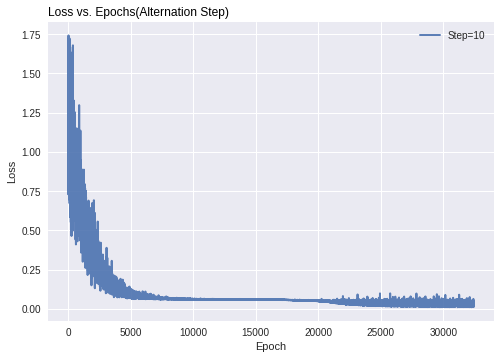

In [35]:
plt.style.use('seaborn')
palette = plt.get_cmap('Set1')

# plt.plot(Loss_redo1[:30],linewidth=2, alpha=0.9, label="Step=1")
# plt.plot(np.mean(np.split(Loss_redo5[:7300], 100),1)[:30],linewidth=2,color='red', alpha=0.9, label="Step=5")
# plt.plot(np.mean(np.split(Loss_redo5_2[:7300], 100),1)[:30], linewidth=2, alpha=0.9, label="Step=10")
# plt.plot(np.mean(np.split(Loss_redo10[:7300], 100)[:30],1),linewidth=2, alpha=0.9, label="Step=30")

plt.plot(all_epoch_loss[10000:], linewidth=2, alpha=0.9, label="Step=10")
# plt.plot(np.mean(np.split(all_epoch_loss[:42400], 424),1), linewidth=2, alpha=0.9, label="Step=10")
plt.legend(loc=1, ncol=1)

plt.title("Loss vs. Epochs", loc='left', fontsize=12, fontweight=0, color='black')
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [5]:

"""
Data_loader is iterable
[ (image1_tensor, label1_tensor), ...]
"""
# If you want path support different dataset, use below
# data_loader = generator.get_path_loader(1, DATA_PATH, shuffle=False)
data_loader = generator.get_VOC_loader(1, "val")
print(len(data_loader))

# Split for visualization
data_nparray = np.array([one_data[0].view(-1).numpy() for one_data in data_loader])
labels_nparray = np.array([one_data[1] for one_data in data_loader])




Using downloaded and verified file: ../data/VOCtrainval_11-May-2012.tar
1449


  1%|          | 9/1449 [00:01<04:40,  5.14it/s]


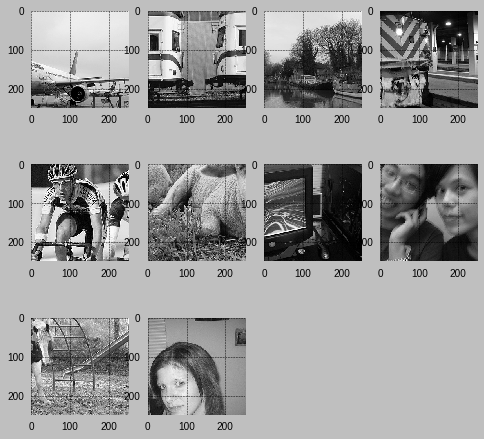

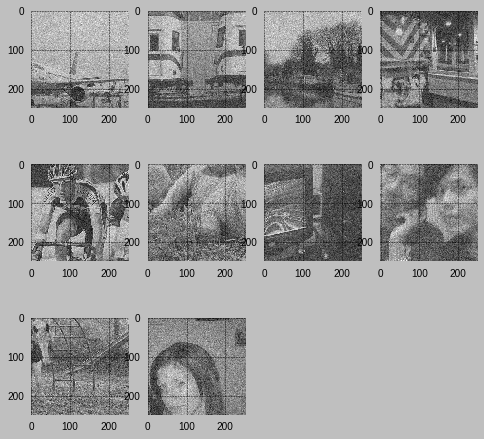

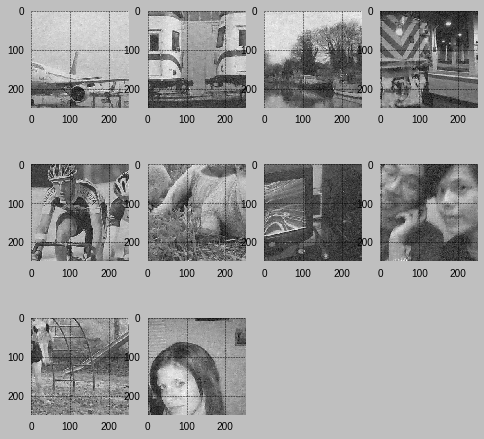

In [52]:
 
test_img_list = []
noisy_img_list = []
embedding_model_np = []
img_model_np = []
num_data = 10
noiseSTD = 30

with torch.no_grad():
    for i, (img_test, _) in enumerate(tqdm(data_loader)):
        test_img_list.append(img_test.numpy())
        noisy_img = (img_test + noiseSTD / 255 * torch.randn(img_test.shape)).to(DEVICE)
        img_new, x_new, _ = result_model(noisy_img)
        noisy_img_list.append(noisy_img.view(-1).to("cpu").detach().numpy())
        embedding_model_np.append(x_new.view(-1).to("cpu").detach().numpy())
        img_model_np.append(img_new.view(-1).to("cpu").detach().numpy())
        if i == num_data-1:
            break

embedding_model_np = np.array(embedding_model_np)

plt.style.use('grayscale')

# Visualize the image itself to see the noisy input
visuals.visualize_img(test_img_list, labels_nparray, (250,250))
visuals.visualize_img(noisy_img_list, labels_nparray, (250,250))
visuals.visualize_img(img_model_np, labels_nparray, (250,250))
    

In [53]:
print(x_new.size())

torch.Size([36, 64, 44, 44])


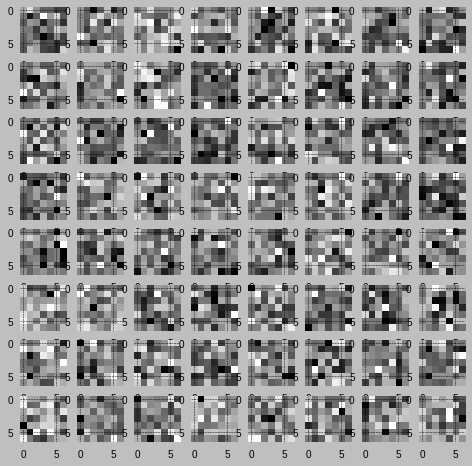

In [54]:
visuals.visualize_dictionary(dictionary.cpu())


In [58]:

FOLDER_PATH = "/home/garysnake/Desktop/crsae/pytorch/results/default/2020_05_25_07_59_16/"

psnr_total = []

PSNR = np.load(FOLDER_PATH + "psnr_init.npy")

for i in range(29):
    PSNR = np.load(FOLDER_PATH + "psnr_epoch{}.npy".format(i))
    psnr_total.append(np.mean(PSNR))
    
np.array(psnr_total)
print(len(psnr_total))
print(np.mean(psnr_total))
print(psnr_total)


29
9.18166171291495
[-74.36604526134309, -54.76800174933773, -39.35218879012063, -28.10645395524805, -18.710072544873213, -10.20712868170395, -2.208545923888943, 5.453310812578592, 12.441261330904828, 17.64927560210953, 20.305067282568555, 21.40970511888356, 21.78722246686926, 21.94292313328014, 21.973801235815547, 22.06140137380381, 22.169858166958246, 22.371266504795933, 22.737987196751664, 23.238543623607168, 24.247239911999475, 25.611810380994008, 26.27896806520196, 26.453522602886764, 26.852558289986845, 27.02161851463733, 27.14410100440097, 27.344565917284655, 27.490618044730297]


Text(0, 0.5, 'Loss')

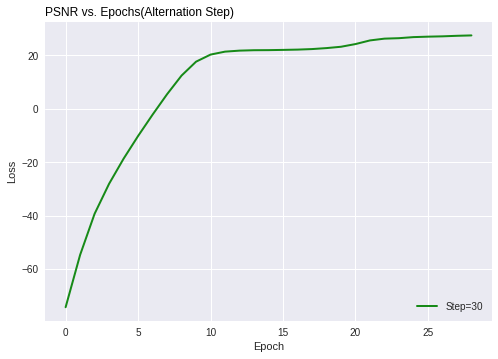

In [61]:
plt.style.use('seaborn')

fig = plt.figure()
ax = fig.add_subplot(111)

palette = plt.get_cmap('Set2')

# plt.plot(psnr_redo1,linewidth=2, marker = 'o', color='red', alpha=0.9, label="Step=1")
# plt.plot(psnr_redo5,linewidth=2, marker = 'v', color=palette(2), alpha=0.9, label="Step10")
# plt.plot(psnr_redo5_2,linewidth=2, marker = 's', color='purple', alpha=0.9, label="Step=5")
# plt.plot(psnr_redo10, color='green', marker = 'x', linewidth=2, alpha=0.9, label="Step=30")


plt.plot(psnr_total, color='green', marker = 'x', linewidth=2, alpha=0.9, label="Step=30")

plt.legend(loc=4, ncol=1)

plt.title("PSNR vs. Epochs(Alternation Step)", loc='left', fontsize=12, fontweight=0, color='black')
plt.xlabel("Epoch")
plt.ylabel("Loss")


